# Multi Layer Perceptron with Keras

Welcome back !

We will now be using a MLP (a Neural Network that also contains at least a hidden layer) to recognise hand written digits in images.

You can use code from the previous tutorial to complete this one.

**Note: it is recommended that you first try with the initial parameters that were proposed, and then add the optimisations that you've tried at the end of the previous tutorial in order to observe their effects.**

Useful links:

> https://en.wikipedia.org/wiki/Multilayer_perceptron

## Import useful code packages

In [1]:
# Standard scientific Python imports
import matplotlib.pyplot as plt
import numpy as np

# Import Keras model layers
import tensorflow as tf
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense, Activation, Dropout

from tensorflow.keras.optimizers import SGD, Adam

## Load the MNIST Dataset

In [2]:
# download and load the MNIST dataset - the file will be downloaded only once and saved in the Anaconda environment
(X_train_raw, y_train_raw), (X_test_raw, y_test_raw) = tf.keras.datasets.mnist.load_data()

# Print shapes and bounds
print('Train set:')
print('Sizes:', X_train_raw.shape, y_train_raw.shape)

print('Test set:')
print('Sizes:', X_test_raw.shape, y_test_raw.shape)

print('Image values (min to max):', np.min(X_train_raw), 'to', np.max(X_train_raw))
print('Label values (min to max):', np.min(y_train_raw), 'to', np.max(y_train_raw))

Train set:
Sizes: (60000, 28, 28) (60000,)
Test set:
Sizes: (10000, 28, 28) (10000,)
Image values (min to max): 0 to 255
Label values (min to max): 0 to 9


## Normalisation

The data was loaded, but the pixel values are not suitable for learning with a Neural Network. Also, labels have to be in one-hot format.

* Divide raw image data in both training and test set by the maximum value

* Flatten the images into 1D vectors. Use NumPy's reshape function:
    https://docs.scipy.org/doc/numpy/reference/generated/numpy.reshape.html

* Convert the raw numeric labels (0..9) to one-hot vectors - Keras has a builtin function to do just that:
    https://www.tensorflow.org/api_docs/python/tf/keras/utils/to_categorical
    

In [3]:
# normalise raw image data by dividing by the maximum value
X_train = X_train_raw / 255 # normalise X_train
X_test = X_test_raw / 255 # normalise X_test

# flatten normalised data into 1D vectors
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

# convert raw labels to one-hot vectors
y_train = tf.keras.utils.to_categorical(y_train_raw, num_classes=10) # convert y_train
y_test = tf.keras.utils.to_categorical(y_test_raw, num_classes=10) # convert y_test

# shuffle training samples (same permutation for X and Y so that labels still correspond)
np.random.seed(42) # fix random seed so that everyone has the same dataset permutation
permutation = np.random.permutation(X_train.shape[0])
X_train = X_train[permutation]
y_train = y_train[permutation]

# Print shapes and bounds
print('### Train set:')
print('Sizes:', X_train.shape, y_train.shape)
print('Image values (min to max):', np.min(X_train), 'to', np.max(X_train))
print('Label values (min to max):', np.min(y_train), 'to', np.max(y_train))
print('Total samples per class:', np.sum(y_train, axis=0))

print('### Test set:')
print('Sizes:', X_test.shape, y_test.shape)
print('Image values (min to max):', np.min(X_test), 'to', np.max(X_test))
print('Label values (min to max):', np.min(y_test), 'to', np.max(y_test))
print('Total samples per class:', np.sum(y_test, axis=0))

### Train set:
Sizes: (60000, 784) (60000, 10)
Image values (min to max): 0.0 to 1.0
Label values (min to max): 0.0 to 1.0
Total samples per class: [5923. 6742. 5958. 6131. 5842. 5421. 5918. 6265. 5851. 5949.]
### Test set:
Sizes: (10000, 784) (10000, 10)
Image values (min to max): 0.0 to 1.0
Label values (min to max): 0.0 to 1.0
Total samples per class: [ 980. 1135. 1032. 1010.  982.  892.  958. 1028.  974. 1009.]


**Expected output:**

\### Train set:<br>
Sizes: (60000, 784) (60000, 10)<br>
Image values (min to max): 0.0 to 1.0<br>
Label values (min to max): 0.0 to 1.0<br>
Total samples per class: [5923. 6742. 5958. 6131. 5842. 5421. 5918. 6265. 5851. 5949.]<br>
\### Test set:<br>
Sizes: (10000, 784) (10000, 10)<br>
Image values (min to max): 0.0 to 1.0<br>
Label values (min to max): 0.0 to 1.0<br>
Total samples per class: [ 980. 1135. 1032. 1010.  982.  892.  958. 1028.  974. 1009.]<br>

## Plot some samples

Change the index to see other samples

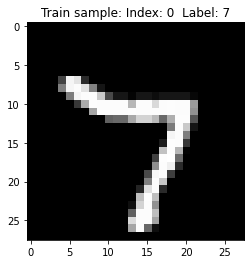

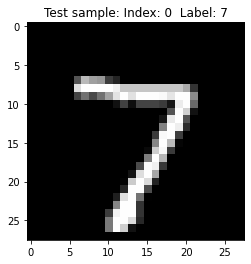

In [4]:
# Just a function to display a sample
def display_digit(index, xs, ys, title):
    label = np.argmax(ys[index]) # argmax used to convert from one-hot back to numeric label
    image = xs[index].reshape([28,28]) # make sure that the data is in 2D shape
    plt.title(title+': Index: %d  Label: %d' % (index, label))
    plt.imshow(image, cmap=plt.get_cmap('gray'))
    plt.show()

display_digit(index=0, xs=X_train, ys=y_train, title='Train sample') # display the first training example
display_digit(index=0, xs=X_test,  ys=y_test,  title='Test sample')  # display the first test example

That's right, the classes seem very easy to separate ! Let's prepare to train our algorithm.

## Define the model

We will build a neural network with a single layer:

* Use Kera's Dense to create two Fully Connected layers:
    * use 'sigmoid' activation for the first one
    * and 'softmax' for the second

![](./images/mlp_diag.png "Multi Layer Perceptron")

In [5]:
# get input and output sizes
input_dim = X_train.shape[1] # 784
hidden_dim = 512 
output_dim = y_train.shape[1] # 10

# Create Sequential model - this allows you to add layers one after the other to build your model
# Create Sequential model - this allows you to add layers one after the other to build your model
model = Sequential()
model.add(Dense(input_dim, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(hidden_dim, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(output_dim, activation='softmax'))


# Compile model
optim = SGD(lr=0.01)
model.compile(optimizer=optim, loss='categorical_crossentropy', metrics=['accuracy'])

## Train the model

> **Note**: Be sure to rerun the previous cell before you train, otherwise previous weights will be kept - i.e. you would just train your model further.

In [6]:
# settings
batch_size = 32
nb_epoch = 100

# train the model and save training history
history = model.fit(X_train, y_train,
          batch_size=batch_size, 
          epochs=nb_epoch, 
          verbose=1, 
          validation_split=1.0/6.0, # set 10K samples (out of 60K) aside for validation
)

# save model weights to file
model.save_weights('mnist_multilayer_perceptron.h5')

Epoch 1/100

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

1563/1563 [==============================] - 2s 2ms/step - loss: 0.8306 - accuracy: 0.7462 - val_loss: 0.3462 - val_accuracy: 0.8978
Epoch 2/100
1563/1563 [==============================] - 2s 2ms/step - loss: 0.4093 - accuracy: 0.8784 - val_loss: 0.2674 - val_accuracy: 0.9196
Epoch 3/100
1563/1563 [==============================] - 2s 2ms/step - loss: 0.3295 - accuracy: 0.8999 - val_loss: 0.2295 - val_accuracy: 0.9313
Epoch 4/100
1563/1563 [==============================] - 2s 2ms/step - lo

1563/1563 [==============================] - 2s 1ms/step - loss: 0.0425 - accuracy: 0.9870 - val_loss: 0.0649 - val_accuracy: 0.9800
Epoch 53/100
1563/1563 [==============================] - 2s 2ms/step - loss: 0.0407 - accuracy: 0.9874 - val_loss: 0.0656 - val_accuracy: 0.9796
Epoch 54/100
1563/1563 [==============================] - 2s 2ms/step - loss: 0.0415 - accuracy: 0.9876 - val_loss: 0.0656 - val_accuracy: 0.9798
Epoch 55/100
1563/1563 [==============================] - 2s 1ms/step - loss: 0.0402 - accuracy: 0.9873 - val_loss: 0.0648 - val_accuracy: 0.9797
Epoch 56/100
1563/1563 [==============================] - 2s 2ms/step - loss: 0.0389 - accuracy: 0.9879 - val_loss: 0.0643 - val_accuracy: 0.9802
Epoch 57/100
1563/1563 [==============================] - 2s 2ms/step - loss: 0.0391 - accuracy: 0.9874 - val_loss: 0.0653 - val_accuracy: 0.9796
Epoch 58/100
1563/1563 [==============================] - 2s 1ms/step - loss: 0.0388 - accuracy: 0.9881 - val_loss: 0.0637 - val_accuracy

## Plot training behaviour

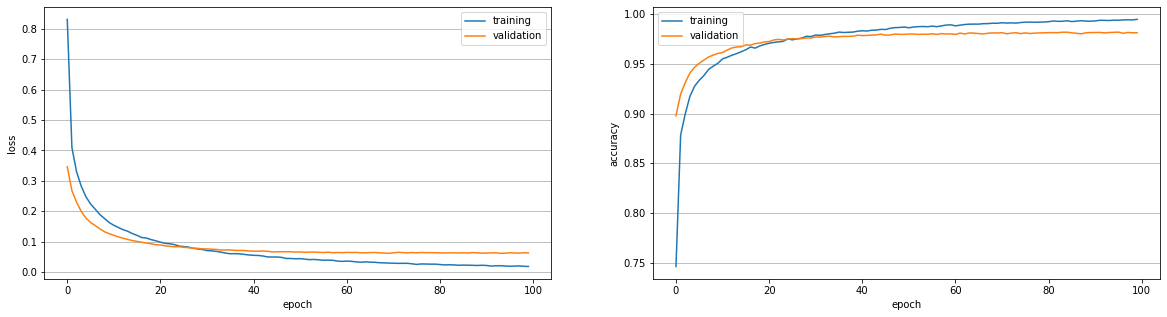

In [7]:
# summarize history for loss and accuracy

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,5))

ax1.plot(history.history['loss'])
ax1.plot(history.history['val_loss'])
ax1.set_ylabel('loss')
ax1.set_xlabel('epoch')
ax1.legend(['training', 'validation'], loc='upper right')
ax1.yaxis.grid()

ax2.plot(history.history['accuracy'])
ax2.plot(history.history['val_accuracy'])
ax2.set_ylabel('accuracy')
ax2.set_xlabel('epoch')
ax2.legend(['training', 'validation'], loc='upper left')
ax2.yaxis.grid()

plt.show()

## Evaluate the model on the test set

In [8]:
# load model weights from file
model.load_weights('mnist_multilayer_perceptron.h5')
model.summary()
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0]) 
print('Test accuracy:', score[1])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                multiple                  615440    
_________________________________________________________________
dropout (Dropout)            multiple                  0         
_________________________________________________________________
dense_1 (Dense)              multiple                  401920    
_________________________________________________________________
dropout_1 (Dropout)          multiple                  0         
_________________________________________________________________
dense_2 (Dense)              multiple                  5130      
Total params: 1,022,490
Trainable params: 1,022,490
Non-trainable params: 0
_________________________________________________________________
Test loss: 0.05840121954679489
Test accuracy: 0.982699990272522


If you followed the instructions and did not haste to apply optimisations (the point here is to learn, not get the best model), you should have obtained a similar accuracy as in the previous tutorial. However, we now have a more complex model, we would like better performance ! (see below)

## Try the following

1) Change the hidden layer activation from 'sigmoid' to 'relu' and retrain ! you should see a huge difference !

2) Add more layers, one by one, and see what happens !

3) Add the optimisations you've made with your Linear Regression model (e.g. momentum, adam optimizer, etc) - the improvements should accumulate

4) Try training for more epochs

5) Can you get to the point where the model overfits the training data ?

6) Share your best results !

## Going further

If you like what you've seen so far, here are some tips to go further:

* try changing the dataset to something more difficult: CIFAR10, CIFAR100

* read more about regularization techniques

* try to get your model to overfit to the point where generalisation decreases

There are so many resources available online in this field !